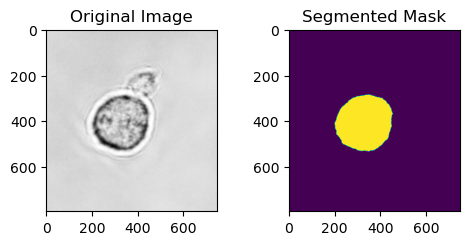

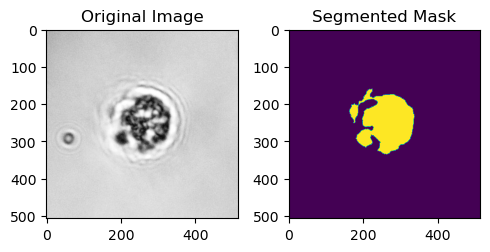

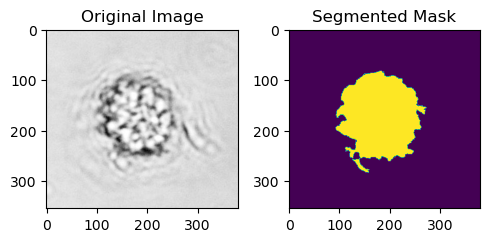

Processing complete. Features extracted and stored in DataFrame.


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage import measure
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops
from scipy import ndimage as ndi

# Define the folder containing images
image_folder = r"D:\FYP\Morphology\cancer cell morph_bf2211_1\cancer cell morph_bf2211_1\sorted_type2"
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Image Name'])

# Conversion factor
pixels_to_um = 0.454

# Loop through all files in the image folder
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):  # Check for JPEG images
        img_path = os.path.join(image_folder, filename)
        
        # Load the image
        img = cv2.imread(img_path, 0)
        
        if img is None:
            print(f"Warning: {filename} not found or could not be loaded.")
            continue
        
        # Generate a binary mask (example: simple thresholding)
        _, thresh = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
        
        mask = thresh < 210  # Change the threshold value as needed
        mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)
        mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)
        
        slc = mask_labeled
        rps = regionprops(slc)
        areas = [r.area for r in rps]
        idxs = np.argsort(areas)[::-1] # we want largest to smallest
        
        new_slc = np.zeros_like(slc)
        for i in idxs[:1]:
            new_slc[tuple(rps[i].coords.T)] = i+1
            
        
        new_slc_filled = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(new_slc)

        # Display the image
        fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))  
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title("Original Image")
        
        
        ax[1].imshow(new_slc_filled)
        ax[1].set_title("Segmented Mask")
        
        
        plt.tight_layout()  # Adjust layout
        plt.show()
        
        # Label the image
        labeled_image = measure.label(new_slc_filled)
        
        # Extract features
        feature = measure.regionprops_table(
            labeled_image,
            properties=('label', 'area', 'centroid', 'equivalent_diameter', 
                        'major_axis_length', 'minor_axis_length', 
                        'orientation', 'perimeter')
        )
        
        features_df = pd.DataFrame(feature)
        
        # Convert properties in the DataFrame
        for index, feature_prop in features_df.iterrows():
            for prop in features_df.columns:
                if prop == 'area':
                    features_df.at[index, prop] = feature_prop[prop] * (pixels_to_um ** 2)
                elif prop in ['perimeter', 'centroid-0', 'centroid-1', 
                              'equivalent_diameter', 'major_axis_length', 
                              'minor_axis_length', 'orientation']:
                    features_df.at[index, prop] = feature_prop[prop] * pixels_to_um
        
        # Add image name to the features DataFrame
        features_df['Image Name'] = filename
        
        # Append to the results DataFrame
        results_df = pd.concat([results_df, features_df], ignore_index=True)

#results_df.to_csv('features_data.csv', index=False)

In [2]:
data = results_df
results_df

,Image Name,label,area,centroid-0,centroid-1,equivalent_diameter,major_axis_length,minor_axis_length,orientation,perimeter
0,tile_x001_y008.jpg,1.0,9998.893276,185.861139,149.784699,112.831673,117.549676,108.580295,-0.399851,405.641449
1,tile_x001_y009.jpg,1.0,3687.827472,113.197333,117.346973,68.523629,74.701788,71.691006,0.492796,460.704509
2,tile_x004_y013.jpg,1.0,4595.562336,78.951569,81.243886,76.493475,81.513816,74.125546,0.012870,443.495370


**Multiclassifier Model**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import xgboost
from xgboost import XGBClassifier

In [4]:
#Divide the data into X : Features, y : BGL
cols = [x for x in data.columns if x!='BGL']
X = data.iloc[:,[ 2, 3,4,5,6,7,8,9]]
y = data['label']

In [20]:
#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf=XGBClassifier(objective='multi:softmax',
                            num_class=3, # liver, lung, breast
                  learning_rate=  0.4185 ,
                  n_estimators= int(18.65))
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
clf=XGBClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
#Confusion Matrix
cf = confusion_matrix(y_test, y_pred,labels=[0,1,2])
group_names = ["0:0","0:1","0:2","1:0","1:1","1:2","2:0","2:1","2:2"]
group_counts = ["{0:0.0f}".format(value) for value in
cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
x_axis_labels = ["Liver","Lung","Breast"] # labels for x-axis
y_axis_labels = ["Liver","Lung","Breast"] # labels for y-axis
ax = sns.heatmap(cf, annot=labels,fmt="",cmap='Blues',linecolor='black',xticklabels=x_axis_labels,yticklabels=y_axis_labels,linewidths=.5)
ax.tick_params(left=False, bottom=False)


ax.set(xlabel='Test Result', ylabel='Truth')

**SVM**

In [ ]:
from sklearn import svm
clf= svm.SVC(probability=True)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('precision:', metrics.precision_score(y_test,y_pred))
print('recall:', metrics.recall_score(y_test,y_pred))
print('roc auc:', metrics.roc_auc_score(y_test,y_pred))

In [ ]:
# need to change the name and the number of the labels
# in the case that all image are cancer cells
print('number of liver in y_train:', np.count_nonzero(y_train), 'out of', len(y_train)) #it was label 1 or 0
print('number of liver in y_test:', np.count_nonzero(y_test), 'out of', len(y_test)) 
print('number of liver in y_pred:', np.count_nonzero(y_pred), 'out of', len(y_pred))